<a href="https://colab.research.google.com/github/R3IYO/NLP_Assignment_4/blob/main/Reiyo_Assignment4(Transformer_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Members
    Reiyo
    Sayed Raheel
    Shashidhar Reddy
    Onkar Kunte

# Part III
Using the previous two tutorials, please answer the following using an encorder-decoder approach and an LSTM compared approach.

Please create a transformer-based classifier for English name classification into male or female.

There are several datasets for name for male or female classification. In subseuqent iterations, this could be expanded to included more classifications.

Below is the source from NLTK, which only has male and female available but could be used for the purposes of this assignment.

```
names = nltk.corpus.names
names.fileids()
['female.txt', 'male.txt']
male_names = names.words('male.txt')
female_names = names.words('female.txt')
[w for w in male_names if w in female_names]
['Abbey', 'Abbie', 'Abby', 'Addie', 'Adrian', 'Adrien', 'Ajay', 'Alex', 'Alexis',
'Alfie', 'Ali', 'Alix', 'Allie', 'Allyn', 'Andie', 'Andrea', 'Andy', 'Angel',
'Angie', 'Ariel', 'Ashley', 'Aubrey', 'Augustine', 'Austin', 'Averil', ...]
```

###__We will build an Transformer based classifier for the names in this notebook__

# Installing Dependencies

In [135]:
!pip install nltk

In [136]:
!pip install imbalanced-learn

# Importing Necessary Libraries

In [137]:
import numpy as np
import tensorflow as tf
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
warnings.filterwarnings('ignore')

# Global Configuration

In [138]:
# Initialising seed for reproducibility
seed =100

#Hyperparameters
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss ='sparse_categorical_crossentropy'
epochs=25

#Download the NLTK names dataset
nltk.download('names')
# Data
names = nltk.corpus.names
male_names = names.words('male.txt')
female_names = names.words('female.txt')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


# Basic EDA and Preprocessing

In [139]:
# Looking at the number of datapoints for male and female names
print('Number of Male names in the dataset : ',len(male_names))
print('Number of Female names in the dataset : ',len(female_names))

Number of Male names in the dataset :  2943
Number of Female names in the dataset :  5001


    Inference : We can see an issue of class imbalanace , so we will treat this first before training the model on this data

In [140]:
# Create a balanced dataset by considering a common subset of names
min_name_count = min(len(male_names), len(female_names))
male_names = male_names[:min_name_count]
female_names = female_names[:min_name_count]

In [141]:
# Looking at the number of datapoints for male and female name after treating the class imbalance.
print('Number of Male names in the dataset : ',len(male_names))
print('Number of Female names in the dataset : ',len(female_names))

Number of Male names in the dataset :  2943
Number of Female names in the dataset :  2943


In [142]:
# Create labeled data
data = [(name, 'male') for name in male_names] + [(name, 'female') for name in female_names]

In [143]:
# Data Preprocessing
names, labels = zip(*data)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)      # Encoding the labels

vocab = set(' '.join(names))
char_to_index = {char: idx for idx, char in enumerate(vocab)}
max_seq_length = max(len(name) for name in names)
data_encoded = np.array([[char_to_index[char] for char in name] for name in names])
data_padded = tf.keras.preprocessing.sequence.pad_sequences(data_encoded, maxlen=max_seq_length)

# Convert labels to numpy arrays
labels_encoded = np.array(labels_encoded)

#Train-Test Split

In [144]:
# Splitting Data
train_data, val_data, train_labels, val_labels = train_test_split(data_padded, labels_encoded, test_size=0.2, random_state=seed)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=seed)
train_data_balanced, train_labels_balanced = smote.fit_resample(train_data, train_labels)

# Model

In [145]:
# Transformer-Based Classifier with Improved Architecture
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def transformer_classifier(input_shape, vocab_size, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128)(inputs)
    positional_encoding_layer = PositionalEncoding(input_shape[0], 128)(embedding_layer)
    attention = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=128)(positional_encoding_layer, positional_encoding_layer)
    attention = tf.keras.layers.GlobalAveragePooling1D()(attention)

    dense = tf.keras.layers.Dense(64, activation='relu')(attention)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(dense)

    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    return model

#Trianing

In [146]:
#Instantiating the shape of inputs and trainng the model
st=time.time()
input_shape = (max_seq_length,)
vocab_size = len(vocab)
num_classes = len(label_encoder.classes_)

transformer_model = transformer_classifier(input_shape, vocab_size, num_classes)
transformer_model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])
transformer_model.fit(train_data_balanced, train_labels_balanced, validation_data=(val_data, val_labels), epochs=epochs)
et=time.time()
print(f'\nExecution Time :{(et-st)/60}minutes\n')
print('-'*60,'Training Complete','-'*60)

Epoch 1/25
150/150 [==============================] - 25s 155ms/step - loss: 0.5999 - accuracy: 0.6372 - val_loss: 0.3934 - val_accuracy: 0.8200
Epoch 2/25
150/150 [==============================] - 26s 176ms/step - loss: 0.4036 - accuracy: 0.8090 - val_loss: 0.3563 - val_accuracy: 0.8396
Epoch 3/25
150/150 [==============================] - 16s 104ms/step - loss: 0.3437 - accuracy: 0.8381 - val_loss: 0.3491 - val_accuracy: 0.8370
Epoch 4/25
150/150 [==============================] - 13s 89ms/step - loss: 0.3453 - accuracy: 0.8370 - val_loss: 0.4052 - val_accuracy: 0.8234
Epoch 5/25
150/150 [==============================] - 13s 88ms/step - loss: 0.3334 - accuracy: 0.8400 - val_loss: 0.3506 - val_accuracy: 0.8251
Epoch 6/25
150/150 [==============================] - 15s 102ms/step - loss: 0.3375 - accuracy: 0.8389 - val_loss: 0.3709 - val_accuracy: 0.8166
Epoch 7/25
150/150 [==============================] - 14s 95ms/step - loss: 0.3228 - accuracy: 0.8427 - val_loss: 0.3479 - val_accur

#Evaluation

In [147]:
#Testing the model
new_names = ['Reiyo', 'Shashi', 'Abby', 'Raheel', 'Halsey']

# Data Preprocessing for Prediction
new_names_encoded = np.array([[char_to_index[char] for char in name] for name in new_names])
new_names_padded = tf.keras.preprocessing.sequence.pad_sequences(new_names_encoded, maxlen=max_seq_length)

# Make Predictions
predictions = transformer_model.predict(new_names_padded)

# Convert predictions to labels
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Print the predictions
for name, label in zip(new_names, predicted_labels):
    print(f"Name: {name}, Predicted Label: {label}")

1/1 [==============================] - 0s 112ms/step
Name: Reiyo, Predicted Label: male
Name: Shashi, Predicted Label: male
Name: Abby, Predicted Label: female
Name: Raheel, Predicted Label: male
Name: Halsey, Predicted Label: female


In [150]:
# Evaluate metrics
val_predictions_transformer = transformer_model.predict(val_data)
val_predicted_labels_transformer = label_encoder.inverse_transform(np.argmax(val_predictions_transformer, axis=1))
val_predicted_labels_transformer_numeric = label_encoder.transform(val_predicted_labels_transformer)

accuracy_transformer = accuracy_score(val_labels, val_predicted_labels_transformer_numeric)
precision_transformer = precision_score(val_labels, val_predicted_labels_transformer_numeric, average='weighted')
recall_transformer = recall_score(val_labels, val_predicted_labels_transformer_numeric, average='weighted')
f1_transformer = f1_score(val_labels, val_predicted_labels_transformer_numeric, average='weighted')
confusion_matrix_transformer = confusion_matrix(val_labels, val_predicted_labels_transformer_numeric)

print("Transformer-Based Classifier Metrics:")
print(f"Accuracy: {accuracy_transformer*100:.4f}%")
print(f"Precision: {precision_transformer:.4f}")
print(f"Recall: {recall_transformer:.4f}")
print(f"F1-Score: {f1_transformer:.4f}")
print("Confusion Matrix:")
print(confusion_matrix_transformer)


37/37 [==============================] - 2s 48ms/step
Transformer-Based Classifier Metrics:
Accuracy: 83.4465%
Precision: 0.8419
Recall: 0.8345
F1-Score: 0.8344
Confusion Matrix:
[[495  58]
 [137 488]]


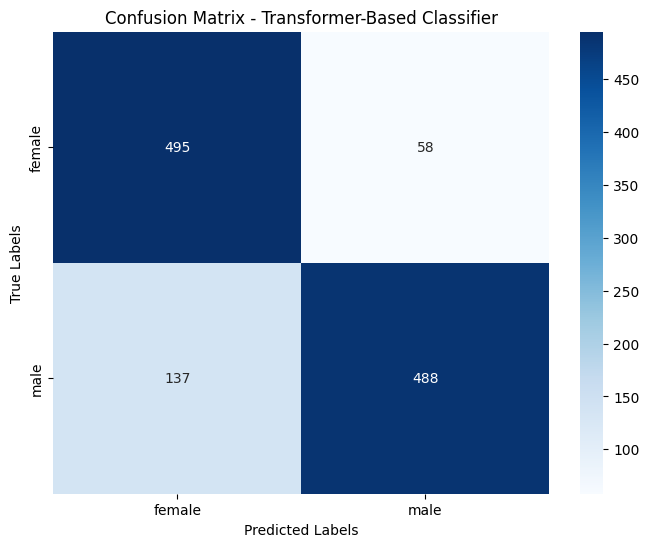

In [149]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_transformer, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Transformer-Based Classifier")
plt.show()

# References
1. https://arxiv.org/pdf/2102.03692.pdf
2. https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/exercise/13-attention.html
3. https://towardsdatascience.com/deep-learning-gender-from-name-lstm-recurrent-neural-networks-448d64553044
4. https://www.nltk.org/book/ch02.html#sec-lexical-resources